# DiffusionDB prompt capture demo

## Imports

### External ibraries

In [1]:
from datasets import load_dataset
import torchvision.transforms as transforms
import json
import matplotlib.pyplot as plt
import torch
import numpy as np

### Internal classes and utility functions

In [2]:
from DecoderWithAttention import DecoderWithAttention
from Encoder import Encoder
from DiffusionDBDataLoader import DiffusionDBDataLoader
from checkpoint_utils import save_checkpoint, load_checkpoint

## Demo

### Parameter setup

In [3]:
class Parameters:
    start_epoch = 0
    epochs = 1 
    epochs_since_improvement = 0 
    batch_size = 1
    device = "cpu"
    max_img_width = 720
    max_img_height = 720

    embedding_dimension = 512 
    attention_dimension = 512
    decoder_dimension = 512 
    dropout_fraction = 0.5

    encoder_lr = 1e-4 
    decoder_lr = 4e-4 
    
    fine_tune_encoder = False 

    grad_clip = 5.
    alpha_c = 1.

    print_freq = 100 

### Load data

In [4]:
dataset = load_dataset('poloclub/diffusiondb', '2m_first_1k')["train"]
images_dataset = dataset["image"]
prompts_dataset = dataset["prompt"]

Found cached dataset diffusiondb (C:/Users/norbe/.cache/huggingface/datasets/poloclub___diffusiondb/2m_first_1k/0.9.1/547894e3a57aa647ead68c9faf148324098f47f2bc1ab6705d670721de9d89d1)


  0%|          | 0/1 [00:00<?, ?it/s]

### Raw input

In [5]:
demo_index = 600

a portrait of a panther portrait, cute and adorable, pretty, beautiful, art portrait, matte fantasy painting, deviantart, super detailed eyes, super detailed, nose, super detailed, eyes, artstation, by jason felix by steve argyle by tyler jacobson by peter mohrbacher, cinematic 


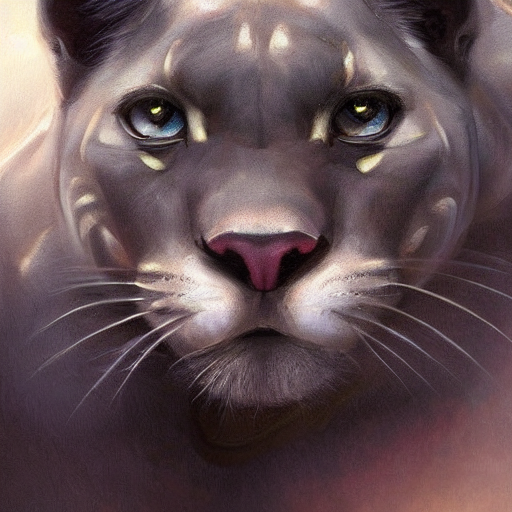

In [6]:
print(prompts_dataset[demo_index])
images_dataset[demo_index]

### Preprocessing

In [7]:
with open('word_map.json') as json_file:
    word_map_dict = json.load(json_file)

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
                                     
demo_loader = DiffusionDBDataLoader(images_dataset[demo_index:demo_index+1], 
                                    prompts_dataset[demo_index:demo_index+1], 
                                    (Parameters.max_img_width, Parameters.max_img_height),
                                    word_map_dict,
                                    Parameters.batch_size, 
                                    transform=normalize,
                                    max_length=15)

Assertions and dimensions
Loading prompts
Setting up transformer
Creating batches


#### Image and prompt after preprocessing

Encoded prompt: [1, 13924, 3619, 18, 13924, 10395, 13924, 1478, 29, 13924, 13924, 13924, 1137, 13924, 9874, 2]


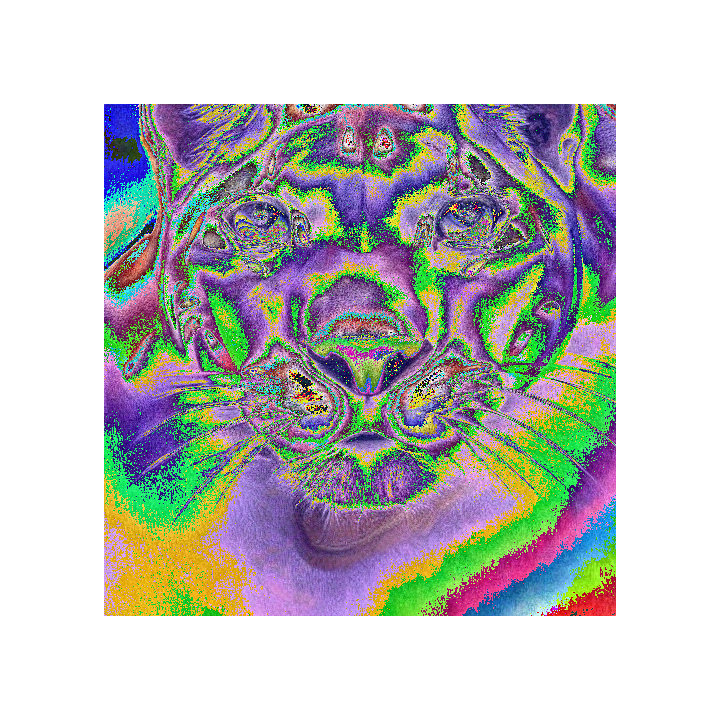

In [8]:
images_transformed, prompts_tokenized, prompts_tokenized_length = next(iter(demo_loader))
image_transformed = images_transformed[0]
prompt_tokenized = prompts_tokenized[0]
print("Encoded prompt:", prompt_tokenized.tolist())
transform_tensor_to_img = transforms.ToPILImage()
transform_tensor_to_img(image_transformed)

### Encoding step

In [9]:
encoder = Encoder()
encoder.fine_tune(Parameters.fine_tune_encoder)
encoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),
                                    lr=Parameters.encoder_lr) if Parameters.fine_tune_encoder else None

decoder = DecoderWithAttention(attention_dimension=Parameters.attention_dimension,
                                embedding_dimension=Parameters.embedding_dimension,
                                decoder_dimension=Parameters.decoder_dimension,
                                vocab_size=len(word_map_dict),
                                dropout_fraction=Parameters.dropout_fraction,
                                device=Parameters.device)
                                
decoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, decoder.parameters()),
                                    lr=Parameters.decoder_lr)



c:\Users\norbe\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\norbe\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Load trained models

In [10]:
encoder, decoder, encoder_optimizer, decoder_optimizer, _, _, _ = load_checkpoint("resnet50_no-unk_15_no_stop", encoder, decoder, encoder_optimizer, decoder_optimizer, best=False)

RuntimeError: Error(s) in loading state_dict for DecoderWithAttention:
	size mismatch for embedding.weight: copying a param with shape torch.Size([13806, 512]) from checkpoint, the shape in current model is torch.Size([13925, 512]).
	size mismatch for fc.weight: copying a param with shape torch.Size([13806, 512]) from checkpoint, the shape in current model is torch.Size([13925, 512]).
	size mismatch for fc.bias: copying a param with shape torch.Size([13806]) from checkpoint, the shape in current model is torch.Size([13925]).

#### Image after encoding

Image shape before encoding: torch.Size([3, 720, 720])
Image shape after encoding: torch.Size([14, 14, 2048])
Examples of convolutional filters


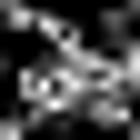

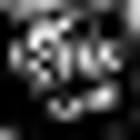

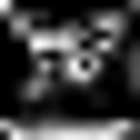

In [ ]:
print("Image shape before encoding:", images_transformed[0].shape)

# Forward prop.
image_transformed_batch = encoder(images_transformed)
print("Image shape after encoding:", image_transformed_batch[0].shape)

convolutional_inputs_to_view = [15,69,420]
scale = 10

print("Examples of convolutional filters")

for conv_i in convolutional_inputs_to_view:
    conv_tensor = image_transformed_batch[0][:, :, conv_i]
    conv_img = transform_tensor_to_img(conv_tensor)
    
    display(conv_img.resize(( int(conv_img.width * scale), int(conv_img.height * scale))))

### Decoding step

In [ ]:
scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(image_transformed_batch, prompts_tokenized, prompts_tokenized_length)

NameError: name 'decoder' is not defined

In [ ]:
print("Words in sentence probabilities for prompt after decoding: \n")
    
print(scores.shape)
print(torch.argmax(scores[0,:,:]))
print(scores)

Words in sentence probabilities for prompt after decoding: 



NameError: name 'scores' is not defined

## Greedy 

In [ ]:
" ".join([list(word_map_dict.keys())[list(word_map_dict.values()).index(torch.argmax(word_prob))] for word_prob in scores[0]])

## Keyword search

In [ ]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

In [ ]:
sentence = []

for word_prob in scores[0]:
    best_word_encoded = torch.topk(word_prob, 2).indices
    for k in best_word_encoded:
        word_candidate = list(word_map_dict.keys())[list(word_map_dict.values()).index(k)]
        if word_candidate not in ["<pad>", "<start>", "<end>", "<unk>"] and word_candidate not in stop_words:
            if word_candidate not in sentence:
                sentence.append(word_candidate)
" ".join(sentence)

'portrait detailed renaissance art highly'

In [ ]:
from tqdm import tqdm
beam_size = 1
device = 'cpu'
vocab_size = len(word_map_dict)
from random import randrange
import torch.nn.functional as F

In [ ]:
for i, (image, caps, caplens) in enumerate(
        tqdm(demo_loader, desc="EVALUATING AT BEAM SIZE " + str(beam_size))):
        
        k = 5
        rand = 3

        imgs = image.to(Parameters.device)
        caps = caps.to(Parameters.device)
        caplens = caplens.to(Parameters.device)

        encoder_out = encoder(imgs)
        encoder_dimension = encoder_out.size(3)
        encoder_out = encoder_out.view(1, -1, encoder_dimension)
        
        num_pixels = encoder_out.size(1)

        encoder_out = encoder_out.expand(k, num_pixels, encoder_dimension)

        k_prev_words = torch.LongTensor([[word_map_dict['<start>']]] * k).to(device)
        seqs = k_prev_words

        top_k_scores = torch.zeros(k, 1).to(device) 

        complete_seqs = list()
        complete_seqs_scores = list()
        incomplete_inds = list()

        step = 1
        h, c = decoder.init_hidden_state(encoder_out)
        
        while True:
        
            embeddings = decoder.embedding(k_prev_words).squeeze(1)  

            awe, _ = decoder.attention(encoder_out, h)  

            gate = decoder.sigmoid(decoder.f_beta(h)) 
            
            h, c = decoder.decode_step(torch.cat([embeddings, awe], dim=-1), (h, c)) 

            scores = decoder.fc(h)
            scores = scores[:,:-1]
            scores = F.log_softmax(scores, dim=1)
            
            scores = top_k_scores.expand_as(scores) + scores
            
            top_k_scores_list, top_k_words_list = list(), list()
            for i in range(k):
                if step == 1:
                    top_k_scores, top_k_words = scores[i].topk(rand, 0, True)  
                else:
                    top_k_scores, top_k_words = scores[i].topk(rand, 0, True)  

                indx = randrange(rand)
                
                top_k_scores_list.append(top_k_scores[indx])
                top_k_words_list.append(top_k_words[indx])
            
            top_k_words = torch.LongTensor(top_k_words_list)
            top_k_scores = torch.Tensor(top_k_scores_list)
            
            prev_word_inds = top_k_words / vocab_size 
            next_word_inds = top_k_words % vocab_size 
            
            prev_word_inds = prev_word_inds.long()
            
            seqs = torch.hstack([seqs, next_word_inds.unsqueeze(1)])
        
            incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if
                        next_word != word_map_dict['<end>']]
            
            complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))
            
            if len(complete_inds) > 0:
                complete_seqs.extend(seqs[complete_inds].tolist())
                complete_seqs_scores.extend(top_k_scores[complete_inds])
            k -= len(complete_inds) 

            if k == 0:
                break
            seqs = seqs[incomplete_inds]
            h = h[prev_word_inds[incomplete_inds]]
            c = c[prev_word_inds[incomplete_inds]]
            encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
            top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
            k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

            if step > 100:
                break
            step += 1
        
        print(complete_seqs_scores)
        joined = []
        for i in range(len(complete_seqs)):
           joined.append(" ".join([list(word_map_dict.keys())[list(word_map_dict.values()).index(ind)] for ind in complete_seqs[i]]))
        print(joined)
        
        

EVALUATING AT BEAM SIZE 1: 100%|██████████| 1/1 [00:03<00:00,  3.56s/it]

[tensor(-33.6728), tensor(-32.4781), tensor(-36.8736), tensor(-35.0184), tensor(-49.5322)]
['<start> highly of with with portrait of black with black of <end>', '<start> highly portrait with of portrait of black art of black <end>', '<start> an of with with portrait with with with with of art <end>', '<start> highly renaissance portrait portrait of of of art with of art <end>', '<start> portrait of with portrait with with black with black black black black art black art <end>']
